**Autor:** [Matej Uhrin](mailto:5283652@upjs.sk)

**Podporné materiály k bakalárskej práci <i>Simulácie vybraných stochastických procesov v interaktívnom prostredí</i>**

***
<br>

**<font size=10 color=brown> Náhodná prechádzka</font>**

<br>

<a id=table_of_contents></a>
##  Obsah
* [Algoritmus simulácie náhodnej prechádzky](#algo)
* [Problém ruinovania hráča](#ruin)
* [Simulácia tenisového setu](#tenis)

<font size=3>Pre návrat na obsah stlačte klávesu Home.</font>
---

In [1]:
# nacitanie balikov
import numpy as np
import matplotlib.pyplot as plt


# metody na vykreslovanie
def plot_gamblers_ruin(S_a, S_b):
    plt.figure(figsize=(8, 5))
    plt.plot(S_a, label="Alica")
    plt.plot(S_b, label="Braňo")
    plt.grid()
    plt.legend()
    plt.xlabel("Kolo")
    plt.ylabel("Stav žetónov")
    plt.title("Ruinovanie hráča - priebeh hry")
    plt.show()


def comparison_plot(real_func, x_values, empiric_values, ylabel, title=""):
    plt.figure(figsize=(8, 6))
    lp = np.linspace(0, 1, 101)
    plt.plot(lp, list(map(real_func, lp)), label="Skutočná hodnota")
    plt.plot(x_values, empiric_values, "ro", label="Empirická hodnota")
    plt.xlabel("P(Hráč vyhrá bod)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

***
<a id=algo><a>
## Algoritmus simulácie náhodnej prechádzky
<blockquote>Algoritmus je pomerne priamočiary a vychádza z definície náhodnej prechádzky.
Nech je daná náhodná prechádzka $\{S_n: n\in\mathbb{N}_0\}$ s počiatočným stavom $S_0$ a krokmi $X_i,\; i=1,2,\dots,n$ pochádzajúcich z toho istého rozdelenia $F(x)$. Potom:

- Zvoľme $k$ - počet krokov, ktoré chceme odsimulovať.
- Pre $i=1,2,\dots,k$ vygenerujme $x_i$ - realizáciu náhodnej veličiny $X_i$.
- Pre $i=0,1,2,\dots,k$ položme $s_i=S_0+\sum\limits_{j=1}^{i}x_j$.

Výsledkom je množina  $\{s_n: n=0,1,2,\dots,k\}$, kde $s_n$ predstavuje stav náhodnej prechádzky po $n$-tom kroku.</blockquote>


Ukážme implementáciu algoritmu v Python-e pre jednoduchú náhodnú prechádzku:

In [3]:
def simple_random_walk(k, p=0.5, S_0=0):
    """
    Vykona realizaciu prvych k krokov jednoduchej nahodnej prechadzky.
    
    :param k:   Pocet krokov simulacie
    :param p:   Pravdepodobnost kroku +1
    :param S_0: Pociatocny stav nahodnej prechadzky
    :return:    Pole dlzky k+1 - realizacia nahodnej prechadzky
    """
    rng = np.random.default_rng()

    S = [S_0]
    for _ in range(k):
        X_i = rng.choice([1, -1], p=[p, 1 - p])
        S.append(S[-1] + X_i)
    return S

Na ukážku odsimulujme 25 krokov jednoduchej náhodnej prechádzky s parametrom $p=0.55$, ktorá začína v $S_0=10$.

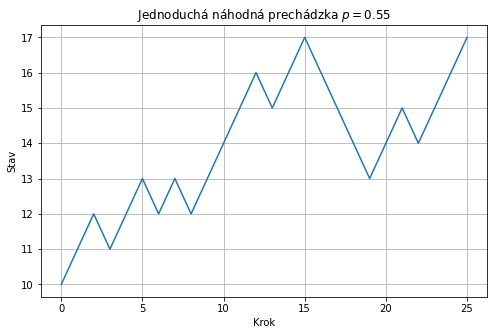

In [7]:
S = simple_random_walk(k=25, p=0.55, S_0=10)

plt.figure(figsize=(8, 5))
plt.plot(S)
plt.grid()
plt.xlabel("Krok")
plt.ylabel("Stav")
plt.title("Jednoduchá náhodná prechádzka $p=0.55$")
plt.show()

***
<a id=ruin><a>
## Problém ruinovania hráča
<blockquote>Alica a Braňo hrajú proti sebe hazardnú hru. Víťaz každého kola hry získava žetón od svojho protivníka. Alica má na začiatku hry $a$ žetónov, Braňo ich má $b$. Pravdepodobnosť, že Alica vyhrá ľubovoľné kolo je $p_a$, zatiaľ čo Braňova pravdepodobnosť výhry je $p_b$, pričom $p_a+p_b=1$. Predpokladáme, že tieto pravdepodobnosti sa počas hry nemenia. Hra končí, keď jeden z hráčov získa všetky žetóny v hre.
Aká je pravdepodobnosť, že hru vyhrá Alica resp. Braňo? Aké je priemerné trvanie hry?</blockquote>

Teoreticky sme ukázali, že:
$$P(\text{Alica vyhrá})=\begin{cases}
\dfrac{1-(p_b/p_a)^a}{1-(p_b/p_a)^{a+b}},\qquad\text{ak }p_a\neq p_b,\\
\frac{a}{a+b},\hspace{2.8cm}\text{ak }p_a= p_b.\end{cases}\qquad\qquad P(\text{Braňo vyhrá})=\begin{cases}
\dfrac{1-(p_a/p_b)^b}{1-(p_a/p_b)^{a+b}},\qquad\text{ak }p_a\neq p_b,\\
\frac{b}{a+b},\hspace{2.8cm}\text{ak }p_a= p_b.\end{cases}$$

$$E[\text{Trvanie hry}] = \begin{cases}
\dfrac{a+b}{p_b-p_a}\dfrac{(p_b/p_a)^a-(p_b/p_a)^{a+b}}{1-(p_b/p_a)^{a+b}}-\dfrac{b}{p_b-p_a},\qquad\text{ak }p_a\neq p_b,\\
ab,\hspace{2.8cm}\text{ak }p_a= p_b.
\end{cases}$$

In [8]:
def gamblers_ruin_simulation(a=10, b=10, p=[0.5, 0.5]):
    '''
    Simulacia jednej hry ruinovania hraca.
    
    :param a: Alicin pociatocny stav zetonov
    :param b: Branov pociatocny stav zetonov
    :param p: Pole [p_a,p_b], kde p_a je pravdepodobnost Alicinej vyhry v kole a p_b je pravdepodobnost Branovej vyhry v kole
    :return:
        winner: vitaz hry, 1 pre Alicu, -1 pre Brana |
        length: trvanie hry |
        S_a: stav Alicinych zetonov pocas hry |
        S_b: stav Branovych zetonov pocas hry
    '''

    rng = np.random.default_rng()

    S_a, S_b = [a], [b]

    while S_a[-1] != 0 and S_b[-1] != 0:
        output = rng.choice([1, -1], p=p)
        S_a.append(S_a[-1] + output)
        S_b.append(S_b[-1] - output)

    winner = "ALICA" if S_b[-1] == 0 else "BRANO"
    return winner, len(S_a[1:]), S_a, S_b

Vykonajme simuláciu jednej hry pre $a=10$, $b=5$ a $(p_a, p_b) = (0.45,0.55)$

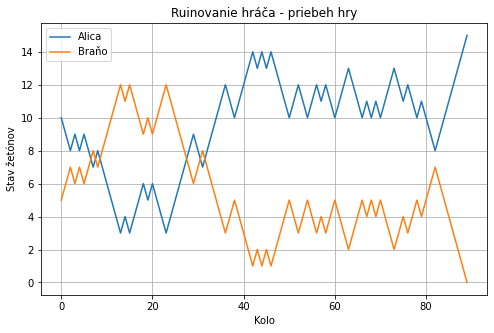

In [9]:
# simulacia jednej hry
winner, length, S_a, S_b = gamblers_ruin_simulation(a=10, b=5, p=[0.45, 0.55])

# vykreslenie priebehu
plot_gamblers_ruin(S_a, S_b)

Pre dané hodnoty sme v práci ukázali:
$$P(\text{Alica vyhrá})=0.3338\qquad\qquad P(\text{Braňo vyhrá})=0.6662$$

$$E[\text{Trvanie hry}] = 49.93$$

Overme tieto hodnoty empiricky:

In [9]:
# volitelny parameter N - pocet opakovani simulacie
N = 10_000

# pocitadla vyhier a dlzky hry
wins = {"ALICA": 0, "BRANO": 0}
durations = []

# simulacia
for _ in range(N):
    winner, length, _, _ = gamblers_ruin_simulation(a=10, b=5, p=[0.45, 0.55])
    wins[winner] += 1
    durations.append(length)

# vypis empirickych vysledkov
print(f"P(Alica vyhra): {wins['ALICA'] / N}")
print(f"P(Brano vyhra): {wins['BRANO'] / N}")
print(f"E[Trvanie hry]: {np.mean(durations)}")

P(Alica vyhra): 0.3347
P(Brano vyhra): 0.6653
E[Trvanie hry]: 49.6297


***
<a id=tenis></a>
## Simulácia tenisového setu
V práci sme sa taktiež venovali simulácii tenisového setu podľa týchto pravidiel:
<blockquote>

- Hru vyhráva ten hráč, ktorý ako prvý získa aspoň 4 body s minimálnym rozdielom 2 bodov.
- Set vyhráva ten hráč, ktorý ako prvý získa aspoň 6 hier s minimálnym rozdielom 2 hier.

Nech $p$ je pravdepodobnosť, že bod získa hráč A a $q$ je pravdepodobnosť, že bod získa hráč B. Pre jednoduchosť predpokladajme, že tieto pravdepodobnosti sa počas setu nemenia.</blockquote>

In [11]:
def tennis_game_sim(probs=[0.5, 0.5]):
    '''
    Simulacia tenisovej hry.

    :param probs: Pravdepodobnosti [p,q] - P(i-ty hrac vyhra bod)
    :return:
        game_winner_idx: index vitaza hry (0 alebo 1) |
        pts_win: stav bodov po skonceni hry (pole velkosti 2)
        P: priebeh hry ako nahodna prechadzka rozdielu bodov
    '''
    rng = np.random.default_rng()

    pts_win = [0, 0]
    P = [0]
    is_game_end = lambda pw=pts_win: abs(pw[1] - pw[0]) >= 2 and max(pw) >= 4

    while not is_game_end():
        pt_winner_idx = rng.choice([0, 1], p=probs)
        pts_win[pt_winner_idx] += 1
        if pt_winner_idx == 0:
            P.append(P[-1] + 1)
        else:
            P.append(P[-1] - 1)

    game_winner_idx = np.argmax(pts_win)
    return game_winner_idx, pts_win, P


def tennis_set_sim(probs=[0.5, 0.5], visualize=False):
    '''
    Simulacia tenisoveho setu s moznostou vizualizacie.

    :param probs: Pravdepodobnosti [p,q] - P(i-ty hrac vyhra bod)
    :param visualize: Bool - vykonanie vizualizacie priebehu
    :return:
        ak visualize je False:
        set_winner_idx: index vitaza setu (0 alebo 1)
        games_win: stav hier po skonceni setu (pole velkosti 2)
        pts_win: stav bodov po skonceni setu (pole velkosti 2)
        P: priebeh setu ako nahodna prechadzka rozdielu bodov
    '''
    games_win = [0, 0]
    pts_win = [0, 0]
    P = [0]

    vis_lines = [(0, 0, 0)]

    is_set_end = lambda gw=games_win: abs(gw[1] - gw[0]) >= 2 and max(gw) >= 6
    while not is_set_end():
        game_winner_idx, game_score, P_ = tennis_game_sim(probs=probs)
        games_win[game_winner_idx] += 1
        pts_win = [pw + gs for pw, gs in zip(pts_win, game_score)]
        P.extend(P[-1] + np.array(P_[1:]))
        vis_lines.append((vis_lines[-1][0] + sum(game_score), *games_win))

    if visualize:
        plt.figure(figsize=(15, 5))
        plt.plot(P, color="black")
        for i, (x, g1, g2) in enumerate(vis_lines):
            plt.axvline(x, color="black", alpha=0.5)
            if i > 0:
                c = "blue" if g1 - vis_lines[i - 1][1] == 1 else "green"
                plt.text((x + vis_lines[i - 1][0]) / 2, max(P), f"{g1}:{g2}", ha="center", weight="bold",
                         size=12)
                plt.axvspan(vis_lines[i - 1][0], x, alpha=0.5, color=c)
        plt.axhline(0, color="red", alpha=1)
        plt.title(f"Vizualizácia priebehu tenisového setu, $p={probs[0]:.2f}$", size=15)
        plt.ylabel("Rozdiel bodov", size=15)
        plt.xlabel("Počet odohraných bodov", size=15)
        plt.show()
        return

    set_winner_idx = np.argmax(games_win)
    return set_winner_idx, games_win, pts_win, P

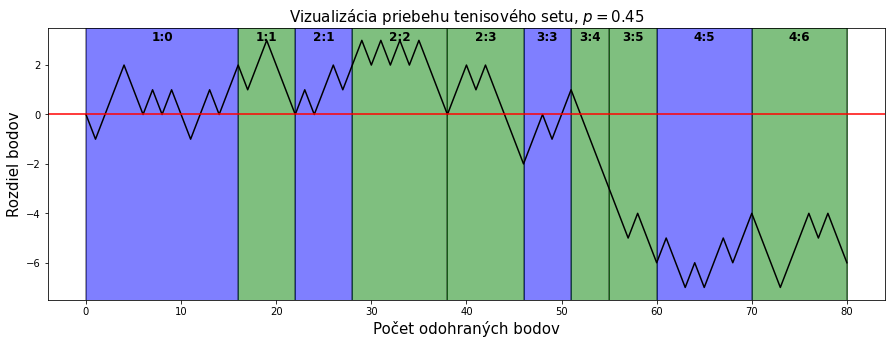

In [13]:
# simulacia tenisoveho setu spolu s jeho vizualizaciou
tennis_set_sim(probs=[0.45, 0.55], visualize=True)

Na záver, empiricky overme naše teoretické úvahy. Nech A je hráč s pravdepodobnosťou výhry $p$ a B je hráč s pravdepodobnosťou $q$.

Potom sme v práci ukázali:

$$p_h=P(\text{A vyhrá hru})=\dfrac{p^4\left(1+2q+4q^2+8q^3\right)}{p^2+q^2}\qquad\qquad q_h=\dfrac{q^4\left(1+2p+4p^2+8p^3\right)}{p^2+q^2}=1-p_h$$

$$P(\text{A vyhrá set})=\dfrac{p_h^6\left(1+4q_h+11q_h^2+26q_h^3+56q_h^4+112q_h^5\right)}{p_h^2+q_h^2}$$

$$E[\text{Počet bodov v hre}]=\dfrac{4\left[6(pq)^3-pq+1\right]}{p^2+q^2}$$

$$E[\text{Počet hier v sete}]=\dfrac{6\left[56(p_hq_h)^5+4(p_hq_h)^4+(p_hq_h)^3-p_hq_h+1\right]}{p_h^2+q_h^2}$$


$$E[\text{Víťazný rozdiel bodov}]=E[\text{Počet hier v sete}]\cdot\dfrac{4\left[p^4(6q^3+q^2+q+1)-q^4(6p^3+p^2+p+1)\right]}{p^2+q^2}$$

In [4]:
## teoreticky odvodene funkcie

def game_win_probability(p):
    q = 1 - p
    return p ** 4 * (1 + 2 * q + 4 * q ** 2 + 8 * q ** 3) / (p * p + q * q)


def set_win_probability(p):
    p_h = game_win_probability(p)
    q_h = 1 - p_h
    return p_h ** 6 * (112 * q_h ** 5 + 56 * q_h ** 4 + 26 * q_h ** 3 + 11 * q_h ** 2 + 4 * q_h + 1) / (
            p_h * p_h + q_h * q_h)


def expected_game_length(p):
    q = 1 - p
    pq = p * q
    return 4 * (6 * pq ** 3 - pq + 1) / (p * p + q * q)


def expected_set_games(p):
    p_h = game_win_probability(p)
    q_h = 1 - p_h
    pq = p_h * q_h
    return 6 * (56 * pq ** 5 + 4 * pq ** 4 + pq ** 3 - pq + 1) / (p_h * p_h + q_h * q_h)


def expected_margin(p):
    q = 1 - p
    return expected_set_games(p) * 4 * (
            p ** 4 * (6 * q ** 3 + q ** 2 + q + 1) - q ** 4 * (6 * p ** 3 + p ** 2 + p + 1)) / (
            p * p + q * q)


In [16]:
# volitelny parameter test values - pole hodnot pravdepodobnosti
test_values = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9]

# volitelny parameter N - pocet simulacii pre kazdu z testovanych pravdepodobnosti
N = 1_000

# pocitadla meranych velicin
game_win_prob_emp = [0] * len(test_values)
set_win_prob_emp = [0] * len(test_values)
exp_pts_in_game_emp = [0] * len(test_values)
exp_games_in_set_emp = [0] * len(test_values)
exp_margin_emp = [0] * len(test_values)

# simulacia pre kazdu z testovacich hodnot
for i, p in enumerate(test_values):

    # inicializacia
    game_wins, set_wins = 0, 0
    n_of_set_pts = []
    n_of_set_games = []
    margins = []
    n_of_games = 0

    for n in range(N):
        # simulacia setu
        winner_idx, games_win, pts_win, _ = tennis_set_sim([p, 1 - p])

        # zapis sledovanych charakteristik
        if winner_idx == 0:
            set_wins += 1
        game_wins += games_win[0]
        n_of_games += sum(games_win)
        n_of_set_games.append(sum(games_win))
        n_of_set_pts.append(sum(pts_win))
        margins.append(pts_win[0] - pts_win[1])

    # vypocet empirickych hodnot
    game_win_prob_emp[i] = game_wins / n_of_games
    set_win_prob_emp[i] = set_wins / N
    exp_pts_in_game_emp[i] = sum(n_of_set_pts) / n_of_games
    exp_games_in_set_emp[i] = np.mean(n_of_set_games)
    exp_margin_emp[i] = np.mean(margins)

Grafy s porovnaním empirických a teoretických výsledkov:

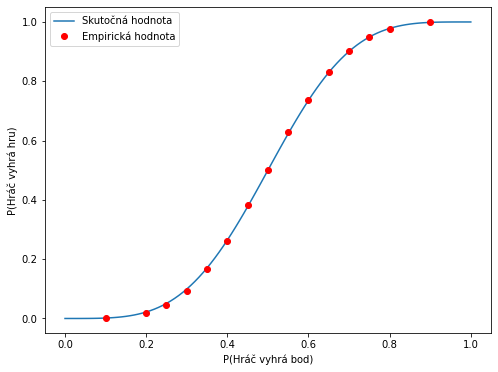

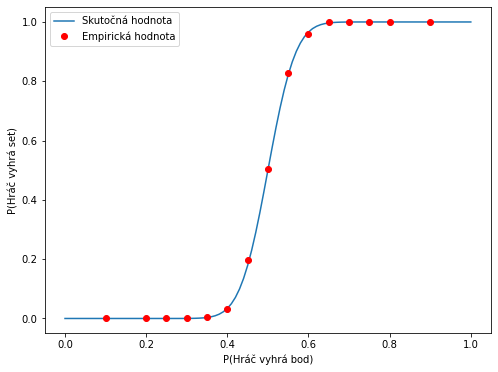

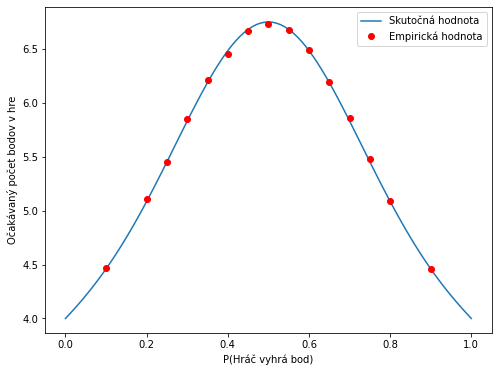

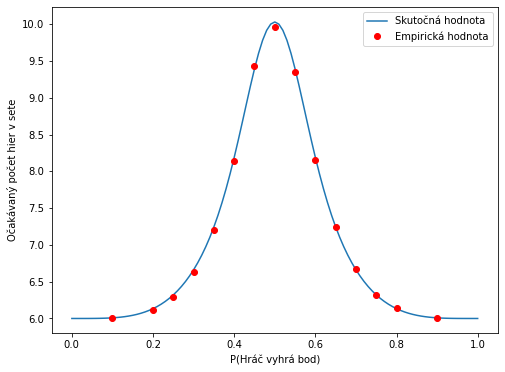

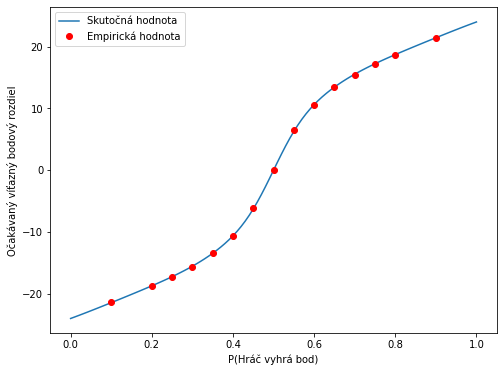

In [17]:
comparison_plot(game_win_probability, test_values, game_win_prob_emp, "P(Hráč vyhrá hru)")
comparison_plot(set_win_probability, test_values, set_win_prob_emp, "P(Hráč vyhrá set)")
comparison_plot(expected_game_length, test_values, exp_pts_in_game_emp, "Očakávaný počet bodov v hre")
comparison_plot(expected_set_games, test_values, exp_games_in_set_emp, "Očakávaný počet hier v sete")
comparison_plot(expected_margin, test_values, exp_margin_emp, "Očakávaný víťazný bodový rozdiel")